In [41]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import linalg, dot
from autograd.numpy.random import multivariate_normal, normal
%matplotlib inline
from matplotlib import pyplot as plt

from ChainNode import ChainNode
from Neighbour import Neighbour

In [42]:
#initialise parameters
N = 10 # Number of iterations
M = 2 # dimensionality of state
L = 2 # dimensionality of output
e = 1e-5 # convergence condition

#Kalman Parameters, linear motion estimation
t_s = 0.1 # sample period
s_p = 1 # process noise variance
s_m = 0.1 # measurement noise variance

#model parameters
A = np.asarray([[1,t_s],[0,1]]) # state transition
B = np.asarray([[np.power(t_s,2)/2],[t_s]]) # noise matrix
C = np.asarray([[0,1]]) # observation matrix
Q = np.asarray([[s_p/64,s_p/16],[s_p/16,s_p/4]]) # Process noise Covariance
R = np.asarray([[s_m]])

#state variables
u = normal(0,s_p,[1,1]).T
z = np.asarray([[1],[1]]) # initial statev
v = normal(0,s_m)
y = np.dot(C,z) + v #initial output

#Kalman filter variables 
P_post = Q
z_post = normal(0,1,[2,1])
z_post = z

#PDMM Parameters
Z = z # state history
U = u # noise history
Y = y # output history

Z_post = z_post #posterior estimate history

# E = linalg.inv(np.block([[Q,np.zeros(M,M)],[np.zeros([M,M]),R]]))
p = 0.001 #step size

In [43]:
# Run kalman simulation
for i in range(N):
    
    z_prior = dot(A,z_post) 
    P_prior = dot(A,dot(P_post,A.T)) + Q
    
    u = normal(0,s_p)
    v = normal(0,s_m)
    z = np.dot(A,z) + np.dot(B,u)
    y = np.dot(C,z) + v
    
    #Perform Kalman filtering, General equation needed for numerical stability
    K_int = 1/(dot(C,dot(P_prior,C.T)) + R )
    K = dot(P_prior,K_int*C.T)
    z_post = z_prior + dot(K,(y - dot(C,z_prior)))
    P_int = np.eye(2) - dot(L,C)
    P_post = dot(dot(P_int,P_prior),P_int.T) + dot(K,dot(R,K.T))
    
    #add new information to history
    Z = np.append(Z,z,axis=1)
    Z_post = np.append(Z_post,z_post,axis=1)
    U = np.append(U,u)
    Y = np.append(Y,y)

In [44]:
# Initialise PDMM Graph

Q_inv = linalg.pinv(Q)
R_int = dot(C,(C/R).T)
P_inv = linalg.inv(P_post)

N_dim = 3
msg_dim = 2
E = np.block([[Q_inv,np.zeros([2,1])],[np.zeros([1,2]),R_int]])
# E_0 = np.block([[Q_inv,np.zeros([2,1])],[np.zeros([1,2]),R_int + P_inv]]), 
#consider funniness introduced by degenerate Q value and pseudoinverses
a_0 = np.block([[np.zeros([1,1])],[dot(Y[0],dot(1/R,C)).T]])

G = [ChainNode(0,N_dim,E,a_0)] 

#initialise nodes
for i in np.arange(N-1)+1:
    a_i = np.block([[np.zeros([1,1])],[dot(Y[i],dot(1/R,C)).T]])
    G.append(ChainNode(i,N_dim,E,a_i))

c_ij = np.zeros([2,1]) 
    
#insert forward neighbours
A_forward = np.block([-B,-A])
for i in np.arange(N-1):
    P_ij = dot(A_forward,dot(linalg.pinv(G[i].E),A_forward.T))
    neighbour = Neighbour(G[i+1],i+1,A_forward,c_ij,P_ij,msg_dim)
    G[i].Neighbours.append(neighbour)

#insert backward neighbours 
A_backward = np.block([np.zeros([2,1]),np.eye(2)])
for i in np.arange(N-1)+1:
    P_ij = dot(A_backward,dot(linalg.pinv(G[i].E),A_backward.T))
    neighbour = Neighbour(G[i-1],i-1,A_backward,c_ij,P_ij,msg_dim)
    G[i].Neighbours.append(neighbour)
    

In [45]:
# Run Synchronous PDMM
N_iter = 1
for i in range(N_iter):
    for node in G:
        node.update()

    for node in G:
        node.finalise()

In [46]:
#collect messages
Z_pdmm = []
for i in range(N):
    Z_pdmm.append(G[i].Neighbours[0].m_ij)
Z_pdmm = np.asarray(Z_pdmm).reshape(10,2)

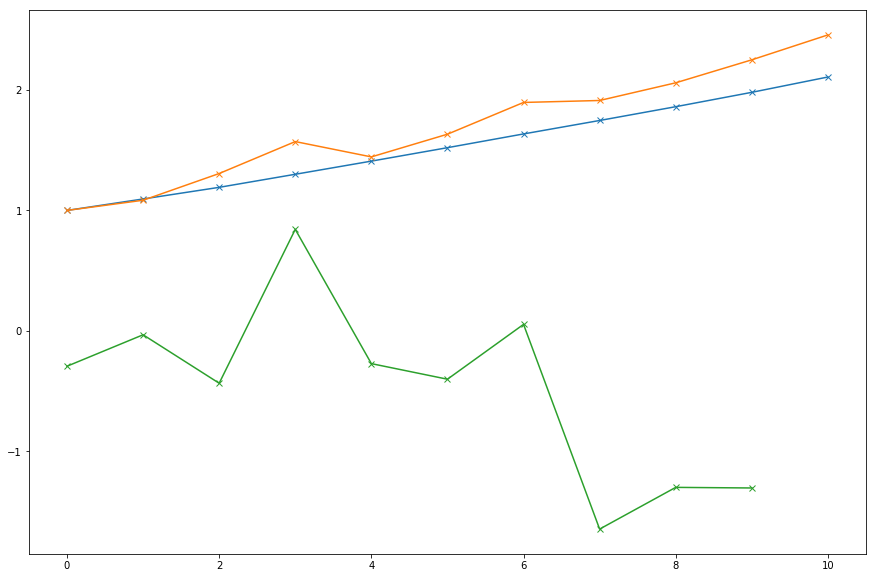

In [48]:
plt.figure(figsize=(15,10))
plt.plot(Z[0,:],'x-')
plt.plot(Z_post[0,:],'x-')
plt.plot(Z_pdmm[:,0],'x-')